In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

seed=47

In [3]:
invoice_test=pd.read_csv("test_invoice.csv",low_memory=False)
invoice_train=pd.read_csv("train_invoice.csv",low_memory=False)
client_train=pd.read_csv("client_train.csv",low_memory=False)
client_test=pd.read_csv("client_test.csv",low_memory=False)

In [4]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60.0,train_Client_0,11.0,101.0,31-12-1994,0.0
1,69.0,train_Client_1,11.0,107.0,29-05-2002,0.0
2,62.0,train_Client_10,11.0,301.0,13-03-1986,0.0
3,69.0,train_Client_100,11.0,105.0,11-07-1996,0.0
4,62.0,train_Client_1000,11.0,303.0,14-10-2014,0.0


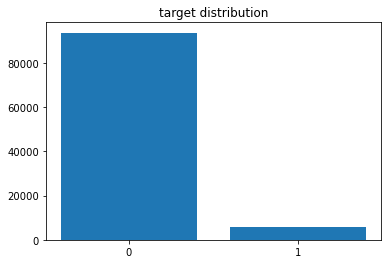

In [6]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

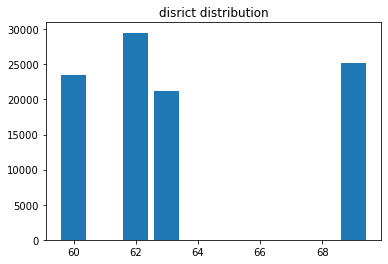

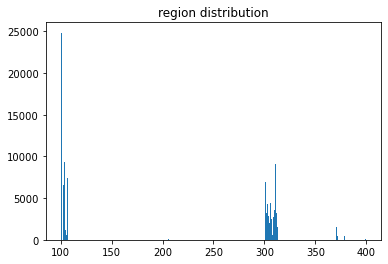

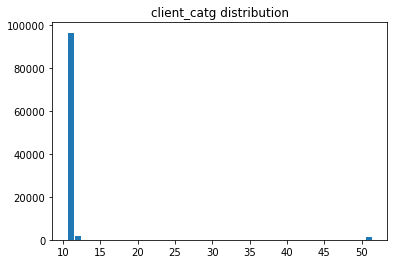

In [7]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [8]:
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 99383
invoice_date - 7869
tarif_type - 15
counter_number - 152122
counter_statue - 10
counter_code - 41
reading_remarque - 7
counter_coefficient - 14
consommation_level_1 - 7433
consommation_level_2 - 11170
consommation_level_3 - 2043
consommation_level_4 - 10636
old_index - 139380
new_index - 141436
months_number - 1134
counter_type - 2


In [9]:
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 99383
client_catg - 3
region - 25
creation_date - 7874
target - 2


In [10]:
invoice_train["counter_statue"].unique()
invoice_train["months_number"].unique()
    
    

array([    4,    12,     8, ..., 18560, 16229,  9545], dtype=int64)

In [11]:
def change_feature(c1,c2):
    
    c1['region_group'] = c1['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    c1['creation_date']= pd.to_datetime(c1['creation_date'])
    c2['counter_type'] = c2['counter_type'].map({"ELEC":1,"GAZ":0})
    c2['counter_statue'] = c2['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5})
    c2['invoice_date']=pd.to_datetime(c2['invoice_date'])
    c2['is_weekday'] = ((pd.DatetimeIndex(c2.invoice_date).dayofweek) // 5 == 1).astype(float)
    c2['delta_index'] =c2['new_index'] - c2['old_index']
    return c1,c2

In [12]:
client_train1,invoice_train1=change_feature(client_train,invoice_train)
client_test1,invoice_test1=change_feature(client_test,invoice_test)

In [13]:
client_train1.head()

,disrict,client_id,client_catg,region,creation_date,target,region_group
0,60.0,train_Client_0,11.0,101.0,1994-12-31,0.0,200
1,69.0,train_Client_1,11.0,107.0,2002-05-29,0.0,200
2,62.0,train_Client_10,11.0,301.0,1986-03-13,0.0,300
3,69.0,train_Client_100,11.0,105.0,1996-11-07,0.0,200
4,62.0,train_Client_1000,11.0,303.0,2014-10-14,0.0,300


In [14]:
invoice_train1

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,is_weekday,delta_index
0,train_Client_0,2014-03-24,11,1335667,0.0,203,8,1,82,0,0,0,14302,14384,4,1,0.0,82
1,train_Client_0,2013-03-29,11,1335667,0.0,203,6,1,1200,184,0,0,12294,13678,4,1,0.0,1384
2,train_Client_0,2015-03-23,11,1335667,0.0,203,8,1,123,0,0,0,14624,14747,4,1,0.0,123
3,train_Client_0,2015-07-13,11,1335667,0.0,207,8,1,102,0,0,0,14747,14849,4,1,0.0,102
4,train_Client_0,2016-11-17,11,1335667,0.0,207,9,1,572,0,0,0,15066,15638,12,1,0.0,572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279690,train_Client_67499,2018-06-25,11,6301121,0.0,410,6,1,402,0,0,0,143382,143784,4,1,0.0,402
3279691,train_Client_67499,2017-02-28,11,6301121,0.0,410,8,1,171,0,0,0,142871,143042,4,1,0.0,171
3279692,train_Client_67499,2016-01-11,11,6301121,0.0,410,8,1,51,0,0,0,142820,142871,2,1,0.0,51
3279693,train_Client_67499,2015-03-11,11,6301121,0.0,410,9,1,438,0,0,0,141762,142200,4,1,0.0,438


In [15]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    
    return full_df

In [16]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'delta_index'
]
train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)


In [17]:
train_df1.head()

,disrict,client_id,client_catg,region,creation_date,target,region_group,is_weekday_mean,transactions_count,tarif_type_mean,...,counter_type_min,counter_type_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_time_mean,delta_time_std,delta_time_min,delta_time_max
0,60.0,train_Client_0,11.0,101.0,1994-12-31,0.0,200,0.028571,35,11.0,...,1,1,362.971429,341.553930,38,1386,144.147059,87.601070,40.0,508.0
1,69.0,train_Client_1,11.0,107.0,2002-05-29,0.0,200,0.054054,37,11.0,...,1,1,557.540541,197.935960,190,1207,136.472222,92.492312,4.0,372.0
2,62.0,train_Client_10,11.0,301.0,1986-03-13,0.0,300,0.055556,18,11.0,...,1,1,836.500000,646.808386,188,3082,289.470588,250.701794,20.0,738.0
3,69.0,train_Client_100,11.0,105.0,1996-11-07,0.0,200,0.050000,20,11.0,...,1,1,1.200000,3.607011,0,15,140.210526,95.569974,4.0,442.0
4,62.0,train_Client_1000,11.0,303.0,2014-10-14,0.0,300,0.285714,14,11.0,...,1,1,922.642857,633.485669,124,2382,121.923077,80.057752,4.0,301.0


In [18]:
   
    def new_features(df):
    
     for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
     return df

In [19]:

train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [20]:
len(train_df2.columns)

97

In [21]:
train_df2.head()

,disrict,client_id,client_catg,region,creation_date,target,region_group,is_weekday_mean,transactions_count,tarif_type_mean,...,old_index_range,old_index_max_mean,new_index_range,new_index_max_mean,months_number_range,months_number_max_mean,counter_type_range,counter_type_max_mean,delta_index_range,delta_index_max_mean
0,60.0,train_Client_0,11.0,101.0,1994-12-31,0.0,200,0.028571,35,11.0,...,12808,1.746299,13269,1.741318,10,2.592593,0,1.0,1348,3.818482
1,69.0,train_Client_1,11.0,107.0,2002-05-29,0.0,200,0.054054,37,11.0,...,19830,1.670533,20361,1.680649,6,1.850000,0,1.0,1017,2.164865
2,62.0,train_Client_10,11.0,301.0,1986-03-13,0.0,300,0.055556,18,11.0,...,16017,1.263408,18640,1.323484,8,1.862069,0,1.0,2894,3.684399
3,69.0,train_Client_100,11.0,105.0,1996-11-07,0.0,200,0.050000,20,11.0,...,9,1.051514,24,1.195595,2,1.428571,0,1.0,15,12.500000
4,62.0,train_Client_1000,11.0,303.0,2014-10-14,0.0,300,0.285714,14,11.0,...,13337,1.932779,12770,1.754937,2,1.076923,0,1.0,2258,2.581714


In [22]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [23]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [24]:
train_df.head()

,disrict,client_catg,region,target,region_group,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,tarif_type_min,...,old_index_range,old_index_max_mean,new_index_range,new_index_max_mean,months_number_range,months_number_max_mean,counter_type_range,counter_type_max_mean,delta_index_range,delta_index_max_mean
0,60.0,11.0,101.0,0.0,200,0.028571,35,11.0,0.0,11,...,12808,1.746299,13269,1.741318,10,2.592593,0,1.0,1348,3.818482
1,69.0,11.0,107.0,0.0,200,0.054054,37,11.0,0.0,11,...,19830,1.670533,20361,1.680649,6,1.850000,0,1.0,1017,2.164865
2,62.0,11.0,301.0,0.0,300,0.055556,18,11.0,0.0,11,...,16017,1.263408,18640,1.323484,8,1.862069,0,1.0,2894,3.684399
3,69.0,11.0,105.0,0.0,200,0.050000,20,11.0,0.0,11,...,9,1.051514,24,1.195595,2,1.428571,0,1.0,15,12.500000
4,62.0,11.0,303.0,0.0,300,0.285714,14,11.0,0.0,11,...,13337,1.932779,12770,1.754937,2,1.076923,0,1.0,2258,2.581714


In [25]:
y = train_df['target']
X = train_df.drop('target',axis=1)

In [26]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean','disrict','client_catg','region']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

In [27]:

from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,X,y)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore

In [30]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))
    
    err = np.mean(res)
    
    return model, err

In [31]:
model = LGBMClassifier(random_state=seed, n_estimators=830,num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105, 
                       feature_fraction=0.3764303138879782, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [32]:
%%time
probs = calc(X, y, model, stkfold)

[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

In [33]:
sample_submission=pd.read_csv("sample_submission.csv")

In [34]:
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })
submission.to_csv('19085111_recognizance_R1.csv', index=False)

In [35]:
r=pd.read_csv("19085111_recognizance_R1.csv")

In [36]:
r.head()

,client_id,target
0,train_Client_675,0.004057
1,train_Client_6750,0.029461
2,train_Client_67500,0.043266
3,train_Client_67501,0.016953
4,train_Client_67502,0.102388


In [37]:
sample_submission.head()

,client_id,target
0,train_Client_675,0
1,train_Client_6750,1
2,train_Client_67500,0
3,train_Client_67501,0
4,train_Client_67502,0
